In [26]:
import re
import pathlib as pl
import tomllib
import colorsys
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from functools import cached_property, partial
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm

from common.project import UnzippedProject
from scatterplots import hr, load_tsv_file, load_txt, EpochInfo
from swarmsim.yaml import safe_load

from seaborn.categorical import _CategoricalPlotter  # pyright: ignore[reportAttributeAccessIssue]
from seaborn.utils import _scatter_legend_artist, _default_color  # pyright: ignore[reportAttributeAccessIssue]

In [27]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
# matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

sideways_dia = MarkerStyle('d', None, Affine2D().rotate_deg(90))

%matplotlib widget

In [12]:
class Run(UnzippedProject):
    @cached_property
    def fitness_df(self):
        data = load_tsv_file(self.popfit_path)
        df = pd.DataFrame(data).T
        df.index = ('time', 'epoch', 'fitnesses')
        df = df.T
        df['time'] = df['time'].astype(float)
        df['epoch'] = df['epoch'].astype(int)
        df['fitnesses'] = df['fitnesses'].apply(eval)
        return df

In [ ]:
folder = pl.Path('~/250108').expanduser()

projects = [Run(p) for p in folder.iterdir() if p.is_dir()]

In [5]:
fitnesses_per_run = [max(p.fitness_df['fitnesses'], default=0) for p in projects]
fitnesses_per_epoch = list(zip(*fitnesses_per_run))
# epoch_idxs = range(len(fitnesses_per_run[0]))

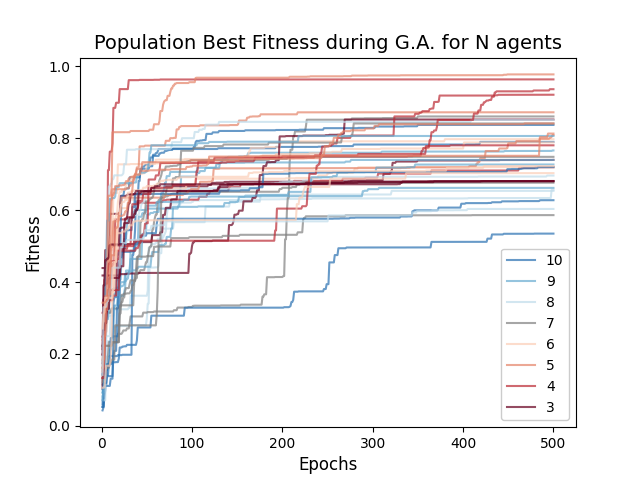

In [ ]:
fig, ax = plt.subplots(1, 1)
ax: plt.Axes

for p in projects:
    best_fitness_per_epoch = p.fitness_df['fitnesses'].apply(max)
    n_robots = p.env['spawners'][0]['n']
    color = cm.RdBu((n_robots - 3)/8) if n_robots != 7 else 'gray'
    ax.plot(p.fitness_df['epoch'], best_fitness_per_epoch, alpha=0.7, c=color, label=n_robots)

plt.xlabel("Epochs")
plt.ylabel("Fitness")
plt.title("Population Best Fitness during G.A. for N agents")
# make legend of unique labels, sorted by label
d = {int(label): handle for handle, label in zip(*ax.get_legend_handles_labels())}
labels = sorted(d.keys())[::-1]
handles = [d[label] for label in labels]
ax.legend(handles, labels, loc='lower right', framealpha=1.0)
%matplotlib widget
# plt.savefig('popfit_n.pdf')


In [13]:
folder = pl.Path('~/neuromorphic/results/sp25').expanduser()


def extract_tenn2_data(project):
    with Run(project) as p:
        _t, _e, fitnesses, *_ = p.read_popfit()
        arr = np.array([li for li in fitnesses if li])
        # epoch_idxs = np.indices(arr.shape)[0]
        max_fitness = np.max(arr)
        n_robots = p.env['spawners'][0]['n']
        # print(f"{p.name}\t{behavior.name}\tN: {n_robots}\tmax: {max_fitness}")
        behavior = p.env['metrics'][0]['name']
        return {
            'behavior': behavior,
            'n_robots': n_robots,
            'max_fitness': max_fitness,
        }


files = [pzip for behavior in folder.iterdir()
         for pzip in list(behavior.iterdir())]

test = extract_tenn2_data(next(iter(files)))
test

{'behavior': 'InteragentDispersion',
 'n_robots': 7,
 'max_fitness': np.float64(7.862073704039821)}

In [14]:
data = process_map(extract_tenn2_data, files)

df = pd.DataFrame(data)
df

  0%|          | 0/418 [00:00<?, ?it/s]

,behavior,n_robots,max_fitness
0,InteragentDispersion,7,7.862074
1,InteragentDispersion,8,8.007349
2,InteragentDispersion,5,8.550547
3,InteragentDispersion,4,8.890730
4,InteragentDispersion,9,7.866218
...,...,...,...
413,Delaunay Dispersal,8,19.946381
414,Delaunay Dispersal,10,6.782931
415,Delaunay Dispersal,10,9.123730
416,Delaunay Dispersal,7,25.069068


In [28]:
def plot_strips(
    self,
    jitter,
    dodge,
    color,
    plot_kws,
):

    width = .8 * self._native_width
    offsets = self._nested_offsets(width, dodge)

    if jitter is True:
        jlim = 0.1
    else:
        jlim = float(jitter)
    if "hue" in self.variables and dodge and self._hue_map.levels is not None:
        jlim /= len(self._hue_map.levels)
    jlim *= self._native_width
    jitterer = partial(np.random.uniform, low=-jlim, high=+jlim)

    iter_vars = [self.orient]
    if dodge:
        iter_vars.append("hue")

    ax = self.ax
    dodge_move = jitter_move = 0

    if "marker" in plot_kws and not MarkerStyle(plot_kws["marker"]).is_filled():
        plot_kws.pop("edgecolor", None)

    using_facets = 'row' in iter_vars or 'col' in iter_vars or self.ax is None
    # add twinx axes for each hue level
    if not using_facets:
        axs = [self.ax]
        for _ in range(1, len(self._hue_map.levels)):
            axs.append(self.ax.twinx())

    for sub_vars, sub_data in self.iter_data(iter_vars,
                                                from_comp_data=True,
                                                allow_empty=True):

        if using_facets:
            ax = self._get_axes(sub_vars)
        else:
            assert sub_data["hue"].nunique() == 1
            idx = self._hue_map.levels.index(sub_data["hue"].iloc[0])
            ax = axs[idx]
            if idx > 1:
                offset = 1 + (idx - 1) * 0.2
                ax.spines.right.set_position(('axes', offset))

        if offsets is not None and (offsets != 0).any():
            dodge_move = offsets[sub_data["hue"].map(self._hue_map.levels.index)]

        jitter_move = jitterer(size=len(sub_data)) if len(sub_data) > 1 else 0

        adjusted_data = sub_data[self.orient] + dodge_move + jitter_move
        sub_data[self.orient] = adjusted_data
        self._invert_scale(ax, sub_data)

        points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
        if "hue" in self.variables:
            points.set_facecolors(self._hue_map(sub_data["hue"]))
        if not using_facets:
            colors = points.get_facecolors()
            avg_color = np.mean(colors, axis=0)
            ax.tick_params(axis='y', colors=avg_color)

    self._configure_legend(ax, _scatter_legend_artist, common_kws=plot_kws)


_CategoricalPlotter.plot_strips = plot_strips

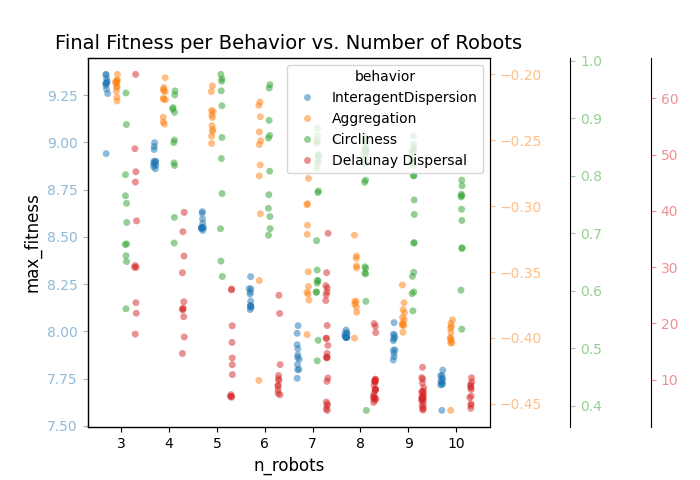

In [29]:
fig = plt.figure()
sns.stripplot(data=df, x='n_robots', y='max_fitness', hue='behavior',
              jitter=True, dodge=True, alpha=0.5, zorder=1, native_scale=True)
fig.subplots_adjust(right=0.7)
fig.set_figwidth(7)

# sns.pointplot(data=df, x='n_robots', y='max_fitness', hue='behavior',
#               dodge=.8 - .8 / 4, palette='dark', markers=sideways_dia, markersize=4, linestyle='none', errorbar=('pi', 100))
plt.title('Final Fitness per Behavior vs. Number of Robots')
plt.savefig('behavior_fitness.pdf')

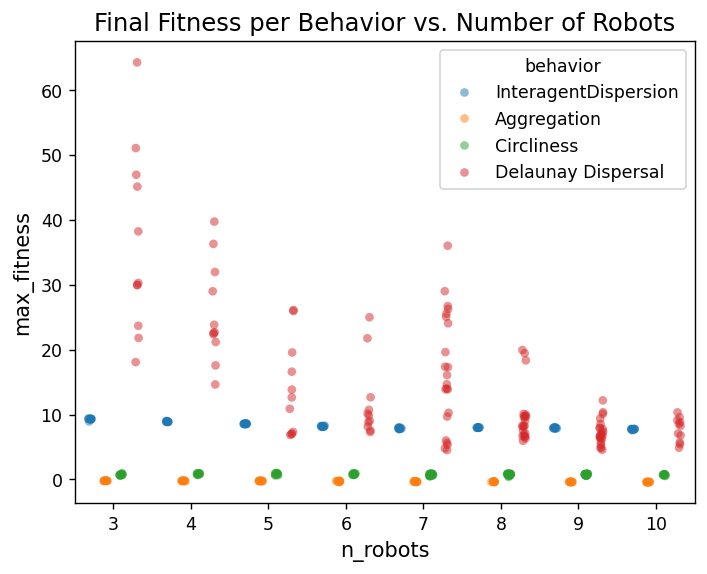

In [59]:
fig